In [89]:
import pandas as pd
import requests
import praw
import re

from datetime import datetime, timedelta
import pytz
from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def clean_headline(headline):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    headline = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", headline).split())
    if 'b ' == headline[:2]:
        headline = headline[2:]
    
    return headline

def calc_textblob_sentiment(headline):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(headline)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
def calc_vader_sentiment(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']

def get_reddit_news_month():
    # New York timezone
    ny = pytz.timezone("America/New_York")
        
    # Get top daily headlines for last month
    # Convert dates to NY time    
    subreddit = reddit.subreddit("worldnews")
    headlines = []
    headline_dates = []
    for submission in subreddit.top("month", limit=1000):
        headlines.append(submission.title)
        headline_dates.append(datetime.fromtimestamp(int(submission.created_utc)).astimezone(ny).date())
    
    # Store in dataframe
    month_news = pd.DataFrame(columns={"Date", "Headline"})
    month_news["Date"] = headline_dates
    month_news["Headline"] = headlines
    month_news.sort_values("Date", inplace=True)
    
    # Merge daily headlines into single string for each date
    # Limit to 25 headlines per date
    headlines = [month_news.iloc[0]["Headline"]]
    count = 0
    for i in range(1, len(month_news)):
        if month_news.iloc[i]["Date"] == month_news.iloc[i-1]["Date"]:
            count += 1
            if count <= 20:
                headlines[-1] = headlines[-1] + " " + month_news.iloc[i]["Headline"]
        else:
            headlines.append(month_news.iloc[i]["Headline"])
            count = 0
            
    # Get unique headline dates
    unique_dates = []
    for date in sorted(headline_dates):
        if date not in unique_dates:
            unique_dates.append(date)
            
    return headlines, unique_dates, month_news

In [90]:
reddit = praw.Reddit(client_id='N377Ru8Wm4bQ0A', \
                     client_secret='sZXrsKN2kMF_c7bayfZQKZQCTAk', \
                     user_agent='headline_scraper', \
                     username='***', \
                     password='***')

In [91]:
df = pd.read_csv('RedditNews.csv')

In [50]:
df.tail()

,Date,News
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."
73607,2008-06-08,"b'Marriage, they said, was reduced to the stat..."


In [51]:
df['cleaned_news'] = [clean_headline(headline) for headline in df['News']]

In [52]:
df.head()

,Date,News,cleaned_news
0,2016-07-01,A 117-year-old woman in Mexico City finally re...,A 117 year old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so...",The president of France says if Brexit won so ...
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...,British Man Who Must Give Police 24 Hours Noti...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...,100 Nobel laureates urge Greenpeace to stop op...


In [53]:
df['textblob_sentiment'] = [calc_textblob_sentiment(headline) for headline in df['cleaned_news']]

In [54]:
analyser = SentimentIntensityAnalyzer()

In [55]:
df['vader_sentiment'] = [calc_vader_sentiment(headline) for headline in df['cleaned_news']]

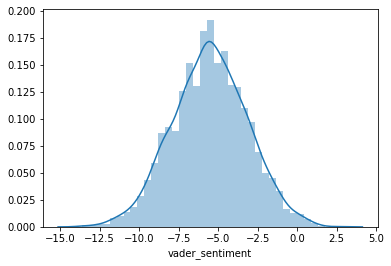

In [56]:
sns.distplot(df[['Date','textblob_sentiment', 'vader_sentiment']].groupby('Date').sum()['vader_sentiment'])
plt.show()

In [57]:
daily_sentiments = df[['Date','textblob_sentiment', 'vader_sentiment']].groupby('Date').sum()
daily_sentiments.head()

,textblob_sentiment,vader_sentiment
Date,,
2008-06-08,-6,-10.1724
2008-06-09,0,-6.4821
2008-06-10,-1,-6.9636
2008-06-11,-1,-4.2609
2008-06-12,0,-2.3130


In [58]:
textblob_values = []
for value in daily_sentiments['textblob_sentiment'].values:
    if value < 0:
        textblob_values.append(-1)
    elif value > 0 :
        textblob_values.append(1)
    else:
        textblob_values.append(0)
        
vader_values = []
for value in daily_sentiments['vader_sentiment'].values:
    if value < -6.0:
        vader_values.append(-1)
    elif value > -5.0 :
        vader_values.append(1)
    else:
        vader_values.append(0)
        
daily_sentiments['textblob_sentiment'] = textblob_values
daily_sentiments['vader_sentiment'] =  vader_values
daily_sentiments.head()

,textblob_sentiment,vader_sentiment
Date,,
2008-06-08,-1,-1
2008-06-09,0,-1
2008-06-10,-1,-1
2008-06-11,-1,1
2008-06-12,0,1


In [59]:
daily_sentiments['textblob_sentiment'].value_counts()

 1    1781
-1     869
 0     293
Name: textblob_sentiment, dtype: int64

In [60]:
daily_sentiments['vader_sentiment'].value_counts()

 1    1216
-1    1194
 0     533
Name: vader_sentiment, dtype: int64

In [61]:
daily_sentiments.to_csv('sentiments.csv')

### Generate New WorldNews Sentiment

In [92]:
headlines_test, unique_dates, news_test = get_reddit_news_month()
news_test['textblob_sentiment'] = [calc_textblob_sentiment(clean_headline(headline)) for headline in news_test['Headline']]
news_test['vader_sentiment'] = [calc_vader_sentiment(clean_headline(headline)) for headline in news_test['Headline']]

daily_sentiments_test = news_test[['Date','textblob_sentiment', 'vader_sentiment']].groupby('Date').sum()

In [95]:
daily_sentiments_test.shift(7)

,textblob_sentiment,vader_sentiment
Date,,
2020-05-25,NaN,NaN
2020-05-26,NaN,NaN
2020-05-27,NaN,NaN
2020-05-28,NaN,NaN
2020-05-29,NaN,NaN
2020-05-30,NaN,NaN
2020-05-31,NaN,NaN
2020-06-01,2.0,-0.1452
2020-06-02,-1.0,-4.5416


In [83]:
news_test['vader_sentiment']

749   -0.7506
891    0.0000
462    0.0000
947    0.4404
848   -0.8316
        ...  
404    0.4019
402    0.3400
401   -0.4588
870   -0.5574
984   -0.5719
Name: vader_sentiment, Length: 985, dtype: float64